In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,mean_absolute_error
from tensorflow.keras.utils import plot_model
from tensorflow import constant_initializer
import matplotlib.pyplot as plt
import json
import shutil
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
import sys
sys.path.append("../code/")
from model import PhasedSNForecastModel
out_steps = 3

In [3]:
def normalize(data, min_val = None, max_val = None):
    masked_data = np.ma.masked_where(data < 0, data)
    min_val = np.tile([0,0,0], (len(data),1)) if min_val is None else min_val
    max_val = np.tile([15, 23, 1],(len(data),1)) if max_val is None else max_val
    
    for i in range(masked_data.shape[1]):
        masked_data.data[:,i,:] = (masked_data.data[:,i,:] - min_val)/(max_val-min_val)
    
    return_data = masked_data.data
    return_data[masked_data.mask] = -1
    return return_data, min_val, max_val
    
def denormalize(data, min_val, max_val):
    masked_data = np.ma.masked_where(data < 0, data)
    
    for i in range(masked_data.shape[1]):
        masked_data.data[:,i,:] = (masked_data.data[:,i,:] * (max_val-min_val))  +  min_val
    
    return_data = masked_data.data
    return_data[masked_data.mask] = -1
    return return_data

In [4]:
data = np.load("../data/padded_x_train.npy")
len_data = data.shape[1]
X_train, y_train = data[:,:-out_steps,:],  data[:,-out_steps:,:]
X_train, data_min_val, data_max_val = normalize(X_train)
y_train, _, _ = normalize(y_train,min_val=data_min_val, max_val=data_max_val)

In [5]:
data_val = np.load("../data/padded_x_val.npy")
len_data = data_val.shape[1]
X_val, y_val = data_val[:,:-out_steps,:],  data_val[:,-out_steps:,:]
X_val, data_val_min_val, data_val_max_val = normalize(X_val)
y_val, _, _ = normalize(y_val,min_val=data_val_min_val,max_val=data_val_max_val)

In [6]:
inputs = X_train
outputs = y_train
inputs_val = X_val
outputs_val = y_val

In [180]:
#Early stops
early_stop = tf.keras.callbacks.EarlyStopping( monitor='val_loss', min_delta=1e-10, patience=10)

#Tensorboard
tensorboard = tf.keras.callbacks.TensorBoard("../data/training/logs/Forecast")
shutil.rmtree("../data/training/logs/Forecast",ignore_errors=True)
#Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint("../data/training/model_checkpoints/checkpoint", monitor='val_loss', verbose=0, save_best_only=True)

callbacks = [tensorboard,checkpoint, early_stop] 

In [181]:
MAX_EPOCHS=1000
model = PhasedSNForecastModel(units=64, out_steps=out_steps,features = 3, dropout=0.0)
losses = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
model.compile(optimizer="rmsprop", loss=losses)
history = model.fit(inputs,outputs,
                    batch_size=300, 
                    epochs=MAX_EPOCHS, 
                    validation_data=(inputs_val,outputs_val), 
                    callbacks=callbacks)

Epoch 1/1000
 1/15 [=>............................] - ETA: 0s - loss: 0.2552

KeyboardInterrupt: 

In [77]:
history_dict = history.history
json.dump(history_dict, open("../data/training/history_model.json", 'w'))

In [78]:
model.save_weights("../data/sn_model_small.h5")

In [172]:
data_test = np.load("../data/padded_x_test.npy")[:,:,:]
# data_test, data_test_min_val, data_test_max_val = normalize(data_test)
X_test, y_test = data_test[:,:-out_steps,:], data_test[:,-out_steps:, :]
X_test, data_test_min_val, data_test_max_val = normalize(X_test)
y_test, _, _ = normalize(y_test,min_val=data_test_min_val, max_val=data_test_max_val)

#Doing inference on Train data
y_hat_train = model.predict(X_train)
#Denormalizing train
dX_train = denormalize(X_train, data_min_val,data_max_val)
dy_hat_train = denormalize(y_hat_train, data_min_val,data_max_val)
dy_train = denormalize(y_train, data_min_val,data_max_val)

# Doing inference on Test data
y_hat = model.predict(X_test)
# Denormalizing results
dX_test = denormalize(X_test, data_test_min_val,data_test_max_val)
dy_hat = denormalize(y_hat,data_test_min_val,data_test_max_val)
dy_test = denormalize(y_test,data_test_min_val,data_test_max_val)

In [173]:
# Plotting results
features = ["Time", "Mag", "Error"]

In [174]:
maes_test = {}
for i, title in enumerate(features):
    maes_test[title] = []
    for t in range(out_steps):
        maes_test[title].append(mean_absolute_error(y_test[:,t,i], y_hat[:,t,i]))

In [175]:
maes_train = {}
for i, title in enumerate(features):
    maes_train[title] = []
    for t in range(out_steps):
        maes_train[title].append(mean_absolute_error(y_train[:,t,i], y_hat_train[:,t,i]))

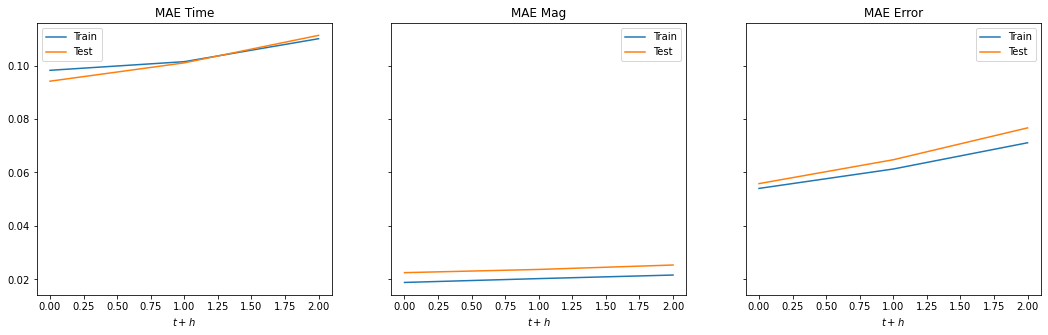

In [176]:
fig,axes = plt.subplots(1,len(features), figsize=(6*len(features),5),sharey=True) 
for i, title in enumerate(features):
    axes[i].plot(maes_train[title], label="Train")
    axes[i].plot(maes_test[title], label="Test")

    axes[i].set_title(f"MAE {title}")
    axes[i].set_xlabel("$t+h$")
    axes[i].legend()

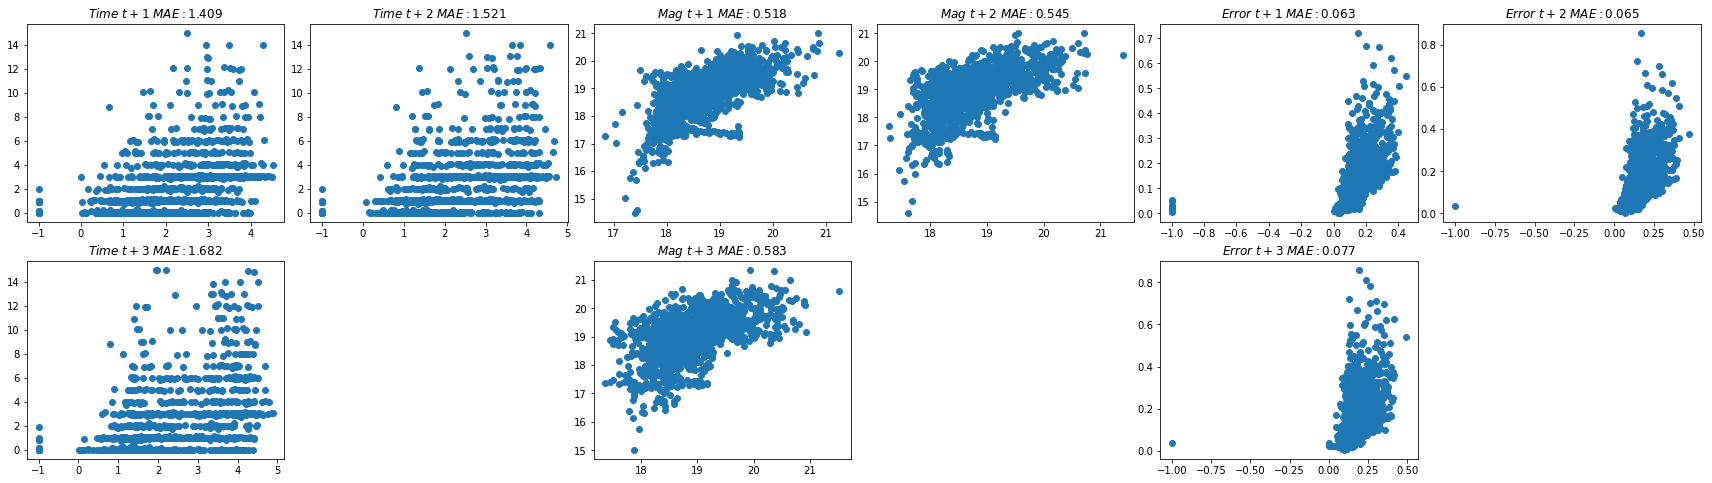

In [177]:
all_rows = np.ceil(out_steps/2).astype(int)
all_columns = len(features)*2
fig2 = plt.figure(figsize=(all_columns*5, all_rows*4))
grid = plt.GridSpec(all_rows, all_columns , wspace=0.1, hspace=0.2)
for i, title in enumerate(features):    
    for t in range(out_steps):
        column = 2*i + (t%2)
        row = t // 2
        
        ax = plt.subplot(grid[row,column])
        mae = mean_absolute_error(dy_test[:,t,i], dy_hat[:,t,i])
        ax.set_title(f"${title} \ t+{t+1} \ MAE:{mae:.3f}$")
        ax.scatter(dy_hat[:,t,i].flatten(),dy_test[:,t,i].flatten())
plt.show()

In [178]:
import os
def plot_data(x, y_real, y_hat, sample=0, save=False, path=""):
    plt.figure(figsize=(12,6))
    plt.gca().invert_yaxis()

    xx = x[sample]
    x_slice = np.where(~(xx[:,1] < 0) )[0]
    unpadded_xx = xx[x_slice,:]
    xx_time = unpadded_xx
    xx_time[:,0] = np.cumsum(xx_time[:,0]) 
    last_time = xx_time[:,0][-1]

    y_real_sample = y_real[sample]
    y_real_sample[:,0] = np.cumsum(y_real_sample[:,0]) + last_time

    y_hat_sample = y_hat[sample]
    y_hat_sample[:,0] = np.cumsum(y_hat_sample[:,0]) + last_time

    plt.scatter(xx_time[:,0], xx_time[:,1], label="History")
    plt.scatter(y_real_sample[:,0], y_real_sample[:,1], label="Real")
    plt.scatter(y_hat_sample[:,0], y_hat_sample[:,1], label="Prediction")
    plt.xlabel("Time $mjd-\min(mjd)$")
    plt.ylabel("Mag")
    plt.legend()
    if save:
        plt.savefig(os.path.join(path, f"{str(sample).rjust(5,'0')}.png"))
        plt.cla()
        plt.clf()
        plt.close()


f = lambda sample: plot_data(dX_test, dy_test, dy_hat,sample=sample)
interact(f, sample=(0,len(dX_test)-1))

interactive(children=(IntSlider(value=728, description='sample', max=1456), Output()), _dom_classes=('widget-i…

<function __main__.<lambda>(sample)>

In [179]:
os.makedirs("../data/plots_test/",exist_ok=True)
g = lambda sample: plot_data(dX_test, dy_test, dy_hat,sample=sample, save=True, path="../data/plots_test/")
for sample in range(len(dX_test)):
    g(sample)